# SM2 — Consolidated Examples (Public Dataset)

This notebook uses the **SM2 public dataset** directly and follows the same style as the other project notebooks.

### Notes
- Timestamps in the dataset are **UTC**; we convert to **Europe/Prague** for local-day/hour aggregations.
- Plots use **matplotlib** (one plot per figure).
- If the Parquet/CSV is not present locally, the loader can download it via Google Drive IDs.


In [ ]:

try:
    import pandas as pd
    import matplotlib
except Exception:
    %pip install -q pandas pyarrow matplotlib gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.figsize'] = (12, 6)

PARQUET_ID = "1gLPWgUGtRb371Gpv5O8t5j95lthNjELg"  # sm2_public_dataset.parquet
CSVGZ_ID  = "1eLOAOZ13--EKE63GZhmerjmY9zkeJcyd"  # sm2_public_dataset.csv.gz
USE_PARQUET = True

parquet_path = Path('sm2_public_dataset.parquet')
csvgz_path   = Path('sm2_public_dataset.csv.gz')

def gdown_download(file_id: str, out_path: Path):
    import subprocess, sys
    try:
        import gdown  # type: ignore
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'gdown'])
        import gdown  # type: ignore
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, str(out_path), quiet=False)

if USE_PARQUET:
    if not parquet_path.exists():
        print('Downloading Parquet…')
        gdown_download(PARQUET_ID, parquet_path)
else:
    if not csvgz_path.exists():
        print('Downloading CSV.GZ…')
        gdown_download(CSVGZ_ID, csvgz_path)

if USE_PARQUET and parquet_path.exists():
    df = pd.read_parquet(parquet_path)
elif csvgz_path.exists():
    df = pd.read_csv(csvgz_path, compression='gzip')
else:
    raise FileNotFoundError('Dataset not found. Place it next to this notebook or enable internet to download.')

df['time'] = pd.to_datetime(df['time'], utc=True, errors='coerce')
df['data_value'] = pd.to_numeric(df['data_value'], errors='coerce')
df['local_time'] = df['time'].dt.tz_convert('Europe/Prague')
df['local_day'] = df['local_time'].dt.floor('D')
df['year'] = df['local_time'].dt.year
print('Shape:', df.shape)
df.head(3)


Downloading...
From: https://drive.google.com/uc?id=1gLPWgUGtRb371Gpv5O8t5j95lthNjELg
To: /content/sm2_public_dataset.parquet
100%|██████████| 1.29M/1.29M [00:00<00:00, 24.8MB/s]


Shape: (651332, 9)


,time,location,source,measurement,data_key,data_value,local_time,local_day,year
0,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_ambient,4.0,2023-11-30 14:00:00+01:00,2023-11-30 00:00:00+01:00,2023
1,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_fresh,20.3,2023-11-30 14:00:00+01:00,2023-11-30 00:00:00+01:00,2023
2,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_indoor,21.4,2023-11-30 14:00:00+01:00,2023-11-30 00:00:00+01:00,2023


## Helper filters
These utility functions keep the analysis cells clean and consistent across notebooks.


In [ ]:

def select_data(source=None, keys=None, locations=None, start=None, end=None):
    q = df.copy()
    if source is not None:
        q = q[q['source'].isin([source] if isinstance(source, str) else list(source))]
    if keys is not None:
        q = q[q['data_key'].isin([keys] if isinstance(keys, str) else list(keys))]
    if locations is not None:
        q = q[q['location'].isin([locations] if isinstance(locations, str) else list(locations))]
    if start is not None:
        q = q[q['local_time'] >= pd.Timestamp(start, tz='Europe/Prague')]
    if end is not None:
        q = q[q['local_time'] <= pd.Timestamp(end, tz='Europe/Prague')]
    return q


## ATREA — Summer 2024 vs 2025 comparative boxplot (with medians above the line)
The following cell **reproduces exactly** the ATREA boxplot section (labels right above the median line with minimal offset).


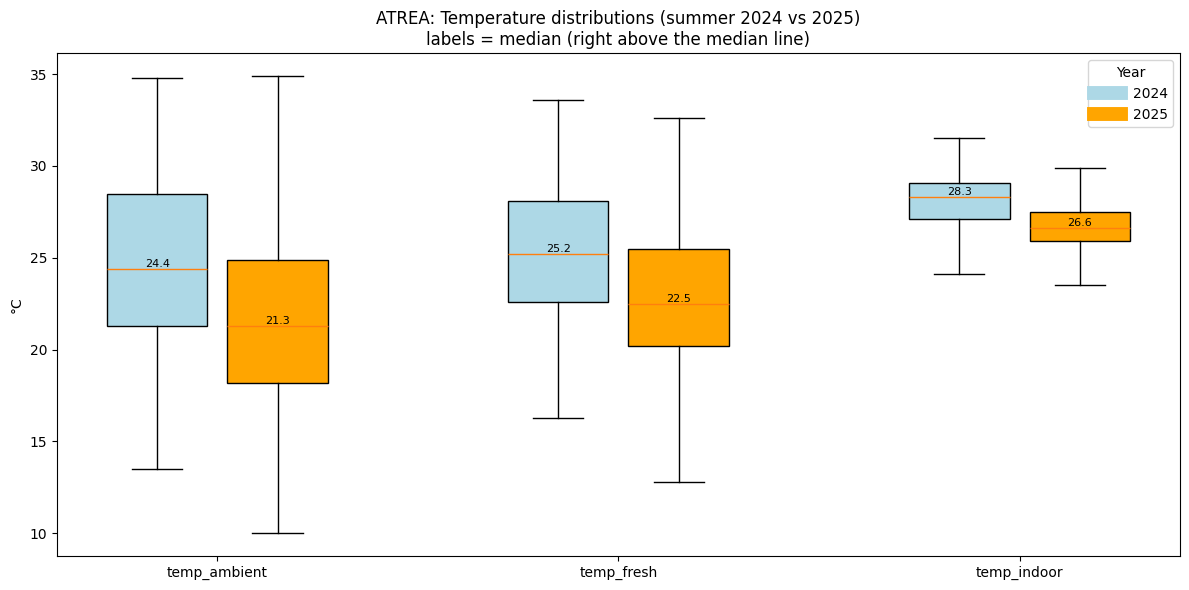

In [ ]:

# ============== ATREA: Summer 2024 vs 2025 — comparative boxplot + median labels directly above the line ==============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def summer_utc_bounds(year: int, tz: str = "Europe/Prague"):
    start_local = pd.Timestamp(f"{year}-06-01 00:00:00", tz=tz)
    end_local   = pd.Timestamp(f"{year}-08-31 23:59:59", tz=tz)
    return start_local.tz_convert("UTC"), end_local.tz_convert("UTC")

# --- data ---
assert "df" in globals(), "Please load the DataFrame `df` first."
if df.columns.duplicated().any():
    df = df.loc[:, ~df.columns.duplicated()].copy()

atrea = df[(df["source"]=="Atrea") & (df["data_key"].isin(["temp_ambient","temp_fresh","temp_indoor"]))].copy()
atrea["time"] = pd.to_datetime(atrea["time"], utc=True, errors="coerce")
atrea = atrea.dropna(subset=["time","data_value"])

keys  = ["temp_ambient","temp_fresh","temp_indoor"]
years = [2024, 2025]

# --- long data (summer for the given year) ---
rows = []
for key in keys:
    s_all = atrea[atrea["data_key"]==key].set_index("time")["data_value"].sort_index()
    for yr in years:
        start_utc, end_utc = summer_utc_bounds(yr)
        s = s_all.loc[(s_all.index>=start_utc) & (s_all.index<=end_utc)].dropna()
        rows.extend({"data_key": key, "year": yr, "data_value": float(v)} for v in s.values)

boxdf = pd.DataFrame(rows)
if boxdf.empty:
    raise ValueError("No summer Atrea data available for the specified years/keys.")

# --- preparation for the boxplot ---
positions, data, colors = [], [], []
offset = 0.3  # spacing between 2024 and 2025 within each metric
for i, key in enumerate(keys):
    vals24 = boxdf[(boxdf["data_key"]==key) & (boxdf["year"]==2024)]["data_value"].values
    vals25 = boxdf[(boxdf["data_key"]==key) & (boxdf["year"]==2025)]["data_value"].values
    positions.extend([i*2 - offset, i*2 + offset])
    data.extend([vals24, vals25])
    colors.extend(["lightblue", "orange"])   # user wants different colors per year

# --- plotting ---
plt.figure(figsize=(12,6))
bp = plt.boxplot(data, positions=positions, widths=0.5, patch_artist=True, showfliers=False)
for patch, c in zip(bp["boxes"], colors):
    patch.set_facecolor(c)

# --- median labels: read directly from the drawn median lines and shift a few points upward ---
# bp["medians"] is a list of Line2D; each has xdata=[x0,x1], ydata=[y,y]
for med_line in bp["medians"]:
    x0, x1 = med_line.get_xdata()
    y0, y1 = med_line.get_ydata()
    x_mid = (x0 + x1) / 2.0
    y_med = (y0 + y1) / 2.0
    # text 0 points above the line (independent of the axis scale)
    plt.annotate(f"{y_med:.1f}",
                 xy=(x_mid, y_med),
                 xytext=(0, 0), textcoords="offset points",
                 ha="center", va="bottom",
                 fontsize=8, color="black", clip_on=False, zorder=3)

# X axis and legend
plt.xticks([i*2 for i in range(len(keys))], keys)
plt.ylabel("°C")
plt.title("ATREA: Temperature distributions (summer 2024 vs 2025)\nlabels = median (right above the median line)")
handles = [plt.Line2D([0],[0], color="lightblue", lw=10),
           plt.Line2D([0],[0], color="orange", lw=10)]
plt.legend(handles, ["2024","2025"], title="Year")

plt.tight_layout()
plt.show()